In [1]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score

In [2]:
def evraz_metric(true_t, predict_t, true_c, predict_c):

    delta_c = np.abs(np.array(true_c) - np.array(predict_c))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(true_t) - np.array(predict_t))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(predict_c)

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

In [3]:
path = Path('../../../data/2021_evraz')

In [12]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
print(target_train.shape)
target_train.head(3)

(2063, 167)


,NPLV,TST,C,VES,T_x,SI,MN,S,P,CR,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,510008,1690,0.060,263700.0,1396.0,0.44,0.22,0.023,0.097,0.03,...,0,2950,2960,980,0,0,0,14080,0,0
1,510009,1683,0.097,264500.0,1419.0,0.68,0.20,0.017,0.087,0.02,...,0,2930,0,960,0,0,1060,18830,0,0
2,510010,1662,0.091,263800.0,1384.0,0.56,0.26,0.017,0.096,0.03,...,0,2990,2960,1050,0,0,990,16080,0,0


In [5]:
test = pd.read_pickle(path.joinpath('test_all.pkl'))
print(test.shape)
test.head(3)

(780, 165)


,NPLV,VES,T_x,SI,MN,S,P,CR,NI,CU,...,NMSYP_Dolomsyr,NMSYP_Ugol_TO,NMSYP_FLUMAG,NMSYP_FlusFOMI,NMSYP_agl_ofl_s,NMSYP_dolom_syr,NMSYP_izvotsev,NMSYP_izv_ZOI,NMSYP_izv_otsev,NMSYP_koks_25_40
0,512324,240100.0,1355.0,0.46,0.33,0.027,0.079,0.01,0.01,0.02,...,0,1310,1670,0,0,0,0,13960,0,0
1,512327,266400.0,1390.0,0.30,0.33,0.032,0.099,0.01,0.00,0.00,...,0,0,0,0,0,0,0,15290,0,50
2,512328,270200.0,1373.0,0.00,0.00,0.000,0.000,0.00,0.00,0.00,...,0,0,0,0,0,0,0,20010,0,1400


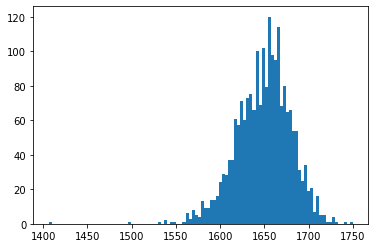

In [7]:
plt.hist(target_train['TST'], bins=100);

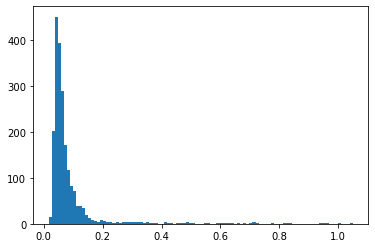

In [8]:
plt.hist(target_train['C'], bins=100);

**Сделаем логарифмирование целевой функции С.**

In [47]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
target_train['C'] = np.log10(target_train['C'])

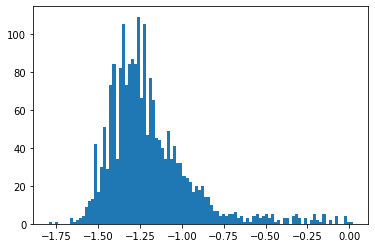

In [48]:
plt.hist(target_train['C'], bins=100);

In [53]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
target_train['C'] = np.log(target_train['C'])

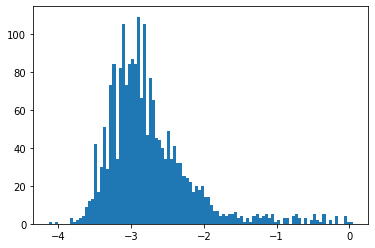

In [54]:
plt.hist(target_train['C'], bins=100);

In [35]:
target_train = pd.read_pickle(path.joinpath('target_train_all.pkl'))
target_train['C'] = np.log2(target_train['C'])

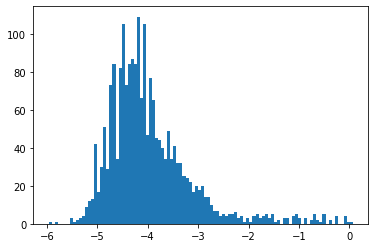

In [36]:
plt.hist(target_train['C'], bins=100);

In [37]:
target_train['C']

0      -4.058894
1      -3.365871
2      -3.457990
3      -1.286304
4      -3.058894
          ...   
2058   -2.785875
2059   -3.522841
2060   -2.826233
2061   -1.888969
2062   -2.450084
Name: C, Length: 2063, dtype: float64

In [40]:
def make_cross_validation(X: pd.DataFrame,
                          y_1: pd.Series,
                          y_2: pd.Series,
                          X_test: pd.DataFrame,
                          estimator_1: object,
                          estimator_2: object,
                          metric: callable,
                          cv_strategy,
                          error_to_be_outlier: None):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y_1: pd.Series
        Вектор 1-й целевой переменной.
        
    y_2: pd.Series
        Вектор 2-й целевой переменной.
        
    X_test: pd.Series
        Матрица признаков для предсказания.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.
        
    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.
        Если ставим 100, это 100% - если 2 раза ошибаемся, то
        говорим, что это выброс.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, fold_valid_scores_2, \
    evraz_metric_train_scores, evraz_metric_valid_scores = [], [], [], [], [], [], []
    oof_predictions_1, oof_predictions_2 = np.zeros(X.shape[0]), np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y_1)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train_1, y_valid_1 = y_1.loc[train_idx], y_1.loc[valid_idx]
        y_train_2, y_valid_2 = y_2.loc[train_idx], y_2.loc[valid_idx]

        estimator_1.fit(x_train, y_train_1)
        estimator_2.fit(x_train, y_train_2)
        y_train_pred_1 = estimator_1.predict(x_train)
        y_train_pred_2 = estimator_2.predict(x_train)
        y_valid_pred_1 = estimator_1.predict(x_valid)
        y_valid_pred_2 = estimator_2.predict(x_valid)

        fold_train_scores_1.append(metric(y_train_1, y_train_pred_1))
        fold_train_scores_2.append(metric(y_train_2, y_train_pred_2))
        
        if not error_to_be_outlier:
            fold_valid_scores_1.append(metric(y_valid_1, y_valid_pred_1))
            fold_valid_scores_2.append(metric(y_valid_2, y_valid_pred_2))
        else:
            mask = ((y_valid_1 - y_valid_pred_1) / y_valid_1) < error_to_be_outlier
            fold_valid_scores_1.append(metric(y_valid_1.loc[mask], y_valid_pred_1[mask]))
            mask = ((y_valid_2 - y_valid_pred_2) / y_valid_2) < error_to_be_outlier
            fold_valid_scores_2.append(metric(y_valid_2.loc[mask], y_valid_pred_2[mask]))
            
        oof_predictions_1[valid_idx] = y_valid_pred_1
        oof_predictions_2[valid_idx] = y_valid_pred_2
        
        evraz_metric_train = evraz_metric(y_train_1, y_train_pred_1, y_train_2, y_train_pred_2)
        evraz_metric_valid = evraz_metric(y_valid_1, y_valid_pred_1, y_valid_2, y_valid_pred_2)
        evraz_metric_train_scores.append(evraz_metric_train)
        evraz_metric_valid_scores.append(evraz_metric_valid)

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score 1 = {round(fold_train_scores_1[fold_number], 4)}, "
            f"train-score 2 = {round(fold_train_scores_2[fold_number], 4)}\n"
            f"valid-score 1 = {round(fold_valid_scores_1[fold_number], 4)}, "
            f"valid-score 2 = {round(fold_valid_scores_2[fold_number], 4)}" 
        )
        print(msg)
        print('Train metric = ', round(evraz_metric_train, 4))
        print('Valid metric = ', round(evraz_metric_valid, 4))
        print("="*69)
        estimators.append(estimator_1)
        estimators.append(estimator_2)

    if not error_to_be_outlier:
        oof_score_1 = metric(y_1, oof_predictions_1)
        oof_score_2 = metric(y_2, oof_predictions_2)
    else:
        mask = ((y_1 - oof_predictions_1) / y_1) < error_to_be_outlier
        oof_score_1 = metric(y_1.loc[mask], oof_predictions_1[mask])
        mask = ((y_2 - oof_predictions_2) / y_1) < error_to_be_outlier
        oof_score_2 = metric(y_2.loc[mask], oof_predictions_2[mask])
        
    print(f"CV-results train 1: {round(np.mean(fold_train_scores_1), 4)} +/- {round(np.std(fold_train_scores_1), 3)}")
    print(f"CV-results train 2: {round(np.mean(fold_train_scores_2), 4)} +/- {round(np.std(fold_train_scores_2), 3)}")
    print(f"CV-results valid 1: {round(np.mean(fold_valid_scores_1), 4)} +/- {round(np.std(fold_valid_scores_1), 3)}")
    print(f"CV-results valid 2: {round(np.mean(fold_valid_scores_2), 4)} +/- {round(np.std(fold_valid_scores_2), 3)}")
    print(f"OOF-score 1 = {round(oof_score_1, 4)}")
    print(f"OOF-score 2 = {round(oof_score_2, 4)}")
    
    print(f"CV-results evraz metric train: {round(np.mean(evraz_metric_train_scores), 4)}\
+/- {round(np.std(evraz_metric_train_scores), 3)}")
    print(f"CV-results evraz metric valid: {round(np.mean(evraz_metric_valid_scores), 4)}\
+/- {round(np.std(evraz_metric_valid_scores), 3)}")
    
    # error fix: ValueError: Feature shape mismatch, expected: 142, got 780
    # https://stackoverflow.com/questions/42338972/valueerror-feature-names-mismatch-in-xgboost-in-the-predict-function
    f_names = estimator_1.get_booster().feature_names 
    X_test = X_test[f_names]
    
    return estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1,\
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, estimator_1.predict(X_test), estimator_2.predict(X_test),\
np.mean(evraz_metric_train_scores), np.mean(evraz_metric_valid_scores)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9262, train-score 2 = 0.9636
valid-score 1 = 0.4053, valid-score 2 = 0.3816
Train metric =  0.5658
Valid metric =  0.3354
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9253, train-score 2 = 0.9678
valid-score 1 = 0.5079, valid-score 2 = 0.5522
Train metric =  0.5752
Valid metric =  0.3789
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9184, train-score 2 = 0.9599
valid-score 1 = 0.5014, valid-score 2 = 0.5262
Train metric =  0.5721
Valid metric =  0.3717
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.925, train-score 2 = 0.9664
valid-score 1 = 0.5836, valid-score 2 = 0.553
Train metric =  0.5651
Valid metric =  0.3859


  4%|███▎                                                                               | 1/25 [00:02<00:49,  2.08s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9333, train-score 2 = 0.951
valid-score 1 = 0.4091, valid-score 2 = 0.5184
Train metric =  0.5627
Valid metric =  0.3786
CV-results train 1: 0.9256 +/- 0.005
CV-results train 2: 0.9617 +/- 0.006
CV-results valid 1: 0.4815 +/- 0.067
CV-results valid 2: 0.5063 +/- 0.064
OOF-score 1 = 0.4911
OOF-score 2 = 0.5163
CV-results evraz metric train: 0.5682+/- 0.005
CV-results evraz metric valid: 0.3701+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9207, train-score 2 = 0.9624
valid-score 1 = 0.4035, valid-score 2 = 0.3773
Train metric =  0.5673
Valid metric =  0.3378
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9239, train-score 2 = 0.9648
valid-score 1 = 0.5072, valid-score 2 = 0.5529
Train metric =  0.5733
Valid metric =  0.3789
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9135, train-score 2 = 0.9573
valid-

  8%|██████▋                                                                            | 2/25 [00:04<00:45,  2.00s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.932, train-score 2 = 0.9501
valid-score 1 = 0.4097, valid-score 2 = 0.5188
Train metric =  0.5615
Valid metric =  0.375
CV-results train 1: 0.9216 +/- 0.006
CV-results train 2: 0.9597 +/- 0.005
CV-results valid 1: 0.4819 +/- 0.067
CV-results valid 2: 0.5056 +/- 0.066
OOF-score 1 = 0.4915
OOF-score 2 = 0.5157
CV-results evraz metric train: 0.5664+/- 0.005
CV-results evraz metric valid: 0.3696+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9163, train-score 2 = 0.9598
valid-score 1 = 0.4043, valid-score 2 = 0.3736
Train metric =  0.5633
Valid metric =  0.3402
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9168, train-score 2 = 0.9614
valid-score 1 = 0.51, valid-score 2 = 0.5512
Train metric =  0.5706
Valid metric =  0.3777
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.908, train-score 2 = 0.9558
valid-scor

 12%|█████████▉                                                                         | 3/25 [00:05<00:41,  1.91s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9238, train-score 2 = 0.9482
valid-score 1 = 0.4122, valid-score 2 = 0.5204
Train metric =  0.553
Valid metric =  0.3714
CV-results train 1: 0.9159 +/- 0.005
CV-results train 2: 0.9571 +/- 0.005
CV-results valid 1: 0.4831 +/- 0.067
CV-results valid 2: 0.5049 +/- 0.067
OOF-score 1 = 0.4925
OOF-score 2 = 0.5151
CV-results evraz metric train: 0.5616+/- 0.006
CV-results evraz metric valid: 0.3686+/- 0.016
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.914, train-score 2 = 0.9581
valid-score 1 = 0.4058, valid-score 2 = 0.3812
Train metric =  0.5612
Valid metric =  0.3414
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9142, train-score 2 = 0.9588
valid-score 1 = 0.5103, valid-score 2 = 0.5495
Train metric =  0.5627
Valid metric =  0.3862
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9035, train-score 2 = 0.9531
valid-s

 16%|█████████████▎                                                                     | 4/25 [00:07<00:39,  1.86s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9213, train-score 2 = 0.9468
valid-score 1 = 0.4109, valid-score 2 = 0.5256
Train metric =  0.5509
Valid metric =  0.3677
CV-results train 1: 0.9124 +/- 0.006
CV-results train 2: 0.9551 +/- 0.005
CV-results valid 1: 0.4824 +/- 0.066
CV-results valid 2: 0.5069 +/- 0.064
OOF-score 1 = 0.4917
OOF-score 2 = 0.5169
CV-results evraz metric train: 0.5591+/- 0.004
CV-results evraz metric valid: 0.3694+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9105, train-score 2 = 0.9569
valid-score 1 = 0.403, valid-score 2 = 0.3813
Train metric =  0.5579
Valid metric =  0.3414
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9056, train-score 2 = 0.9569
valid-score 1 = 0.5144, valid-score 2 = 0.5497
Train metric =  0.5561
Valid metric =  0.3838
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9003, train-score 2 = 0.9518
valid-

 20%|████████████████▌                                                                  | 5/25 [00:09<00:36,  1.83s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9151, train-score 2 = 0.9427
valid-score 1 = 0.4295, valid-score 2 = 0.5258
Train metric =  0.5409
Valid metric =  0.3859
CV-results train 1: 0.9076 +/- 0.005
CV-results train 2: 0.9528 +/- 0.005
CV-results valid 1: 0.4859 +/- 0.063
CV-results valid 2: 0.5072 +/- 0.064
OOF-score 1 = 0.494
OOF-score 2 = 0.5172
CV-results evraz metric train: 0.5536+/- 0.007
CV-results evraz metric valid: 0.3735+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9083, train-score 2 = 0.9532
valid-score 1 = 0.4285, valid-score 2 = 0.3805
Train metric =  0.5515
Valid metric =  0.3499
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8945, train-score 2 = 0.9534
valid-score 1 = 0.5118, valid-score 2 = 0.551
Train metric =  0.5442
Valid metric =  0.3862
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8975, train-score 2 = 0.9513
valid-s

 24%|███████████████████▉                                                               | 6/25 [00:11<00:35,  1.89s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9055, train-score 2 = 0.9387
valid-score 1 = 0.4325, valid-score 2 = 0.5291
Train metric =  0.54
Valid metric =  0.3823
CV-results train 1: 0.9021 +/- 0.005
CV-results train 2: 0.9499 +/- 0.006
CV-results valid 1: 0.4911 +/- 0.056
CV-results valid 2: 0.5078 +/- 0.064
OOF-score 1 = 0.4994
OOF-score 2 = 0.5177
CV-results evraz metric train: 0.5486+/- 0.006
CV-results evraz metric valid: 0.3745+/- 0.013
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.9009, train-score 2 = 0.9496
valid-score 1 = 0.4294, valid-score 2 = 0.3791
Train metric =  0.5485
Valid metric =  0.3547
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8861, train-score 2 = 0.9487
valid-score 1 = 0.5114, valid-score 2 = 0.5529
Train metric =  0.5421
Valid metric =  0.3886
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8959, train-score 2 = 0.9504
valid-s

 28%|███████████████████████▏                                                           | 7/25 [00:13<00:32,  1.81s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.9009, train-score 2 = 0.9366
valid-score 1 = 0.4388, valid-score 2 = 0.5277
Train metric =  0.5382
Valid metric =  0.3896
CV-results train 1: 0.8955 +/- 0.005
CV-results train 2: 0.947 +/- 0.005
CV-results valid 1: 0.4926 +/- 0.054
CV-results valid 2: 0.5075 +/- 0.065
OOF-score 1 = 0.5006
OOF-score 2 = 0.5175
CV-results evraz metric train: 0.5449+/- 0.005
CV-results evraz metric valid: 0.3774+/- 0.013
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8989, train-score 2 = 0.9433
valid-score 1 = 0.4273, valid-score 2 = 0.3763
Train metric =  0.5442
Valid metric =  0.3523
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8798, train-score 2 = 0.9442
valid-score 1 = 0.515, valid-score 2 = 0.5544
Train metric =  0.5327
Valid metric =  0.3874
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8894, train-score 2 = 0.947
valid-sc

 32%|██████████████████████████▌                                                        | 8/25 [00:14<00:29,  1.74s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8945, train-score 2 = 0.9344
valid-score 1 = 0.4443, valid-score 2 = 0.528
Train metric =  0.5333
Valid metric =  0.3835
CV-results train 1: 0.8899 +/- 0.007
CV-results train 2: 0.943 +/- 0.005
CV-results valid 1: 0.4937 +/- 0.053
CV-results valid 2: 0.5072 +/- 0.067
OOF-score 1 = 0.5012
OOF-score 2 = 0.5172
CV-results evraz metric train: 0.5379+/- 0.005
CV-results evraz metric valid: 0.3769+/- 0.013
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8906, train-score 2 = 0.9415
valid-score 1 = 0.439, valid-score 2 = 0.3766
Train metric =  0.5385
Valid metric =  0.3535
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.877, train-score 2 = 0.937
valid-score 1 = 0.5159, valid-score 2 = 0.5548
Train metric =  0.5258
Valid metric =  0.3874
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8821, train-score 2 = 0.9443
valid-scor

 36%|█████████████████████████████▉                                                     | 9/25 [00:16<00:26,  1.68s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8869, train-score 2 = 0.9288
valid-score 1 = 0.461, valid-score 2 = 0.5283
Train metric =  0.5257
Valid metric =  0.3968
CV-results train 1: 0.8837 +/- 0.005
CV-results train 2: 0.9383 +/- 0.005
CV-results valid 1: 0.4998 +/- 0.048
CV-results valid 2: 0.5086 +/- 0.067
OOF-score 1 = 0.5064
OOF-score 2 = 0.5185
CV-results evraz metric train: 0.5316+/- 0.006
CV-results evraz metric valid: 0.3822+/- 0.015
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8842, train-score 2 = 0.9354
valid-score 1 = 0.4372, valid-score 2 = 0.3743
Train metric =  0.5348
Valid metric =  0.3511
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8698, train-score 2 = 0.9306
valid-score 1 = 0.5209, valid-score 2 = 0.5567
Train metric =  0.52
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8702, train-score 2 = 0.9414
valid-sc

 40%|████████████████████████████████▊                                                 | 10/25 [00:17<00:24,  1.66s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8802, train-score 2 = 0.9259
valid-score 1 = 0.461, valid-score 2 = 0.5221
Train metric =  0.53
Valid metric =  0.392
CV-results train 1: 0.8752 +/- 0.006
CV-results train 2: 0.934 +/- 0.005
CV-results valid 1: 0.502 +/- 0.049
CV-results valid 2: 0.5058 +/- 0.067
OOF-score 1 = 0.5088
OOF-score 2 = 0.5159
CV-results evraz metric train: 0.5289+/- 0.005
CV-results evraz metric valid: 0.38+/- 0.015
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8688, train-score 2 = 0.9328
valid-score 1 = 0.4359, valid-score 2 = 0.3738
Train metric =  0.5252
Valid metric =  0.3438
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8616, train-score 2 = 0.9271
valid-score 1 = 0.5211, valid-score 2 = 0.5549
Train metric =  0.5176
Valid metric =  0.3814
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8592, train-score 2 = 0.9386
valid-score 1

 44%|████████████████████████████████████                                              | 11/25 [00:19<00:22,  1.59s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8704, train-score 2 = 0.9219
valid-score 1 = 0.4598, valid-score 2 = 0.5229
Train metric =  0.5227
Valid metric =  0.3932
CV-results train 1: 0.865 +/- 0.004
CV-results train 2: 0.9309 +/- 0.006
CV-results valid 1: 0.5001 +/- 0.049
CV-results valid 2: 0.5056 +/- 0.067
OOF-score 1 = 0.5067
OOF-score 2 = 0.5157
CV-results evraz metric train: 0.5227+/- 0.004
CV-results evraz metric valid: 0.3762+/- 0.017
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8544, train-score 2 = 0.9311
valid-score 1 = 0.4382, valid-score 2 = 0.3727
Train metric =  0.5209
Valid metric =  0.3426
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.841, train-score 2 = 0.9196
valid-score 1 = 0.5217, valid-score 2 = 0.5538
Train metric =  0.5039
Valid metric =  0.3923
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8454, train-score 2 = 0.9341
valid-s

 48%|███████████████████████████████████████▎                                          | 12/25 [00:20<00:19,  1.53s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8611, train-score 2 = 0.915
valid-score 1 = 0.4584, valid-score 2 = 0.5133
Train metric =  0.5133
Valid metric =  0.3823
CV-results train 1: 0.8508 +/- 0.007
CV-results train 2: 0.9258 +/- 0.007
CV-results valid 1: 0.4993 +/- 0.049
CV-results valid 2: 0.5025 +/- 0.067
OOF-score 1 = 0.506
OOF-score 2 = 0.5126
CV-results evraz metric train: 0.5138+/- 0.006
CV-results evraz metric valid: 0.3769+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8371, train-score 2 = 0.9271
valid-score 1 = 0.4332, valid-score 2 = 0.3706
Train metric =  0.5118
Valid metric =  0.345
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8275, train-score 2 = 0.917
valid-score 1 = 0.5132, valid-score 2 = 0.5556
Train metric =  0.5012
Valid metric =  0.3935
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8276, train-score 2 = 0.9292
valid-sco

 52%|██████████████████████████████████████████▋                                       | 13/25 [00:21<00:17,  1.45s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8438, train-score 2 = 0.9092
valid-score 1 = 0.4611, valid-score 2 = 0.5117
Train metric =  0.5033
Valid metric =  0.3762
CV-results train 1: 0.8332 +/- 0.006
CV-results train 2: 0.9215 +/- 0.007
CV-results valid 1: 0.4936 +/- 0.049
CV-results valid 2: 0.5022 +/- 0.068
OOF-score 1 = 0.5
OOF-score 2 = 0.5125
CV-results evraz metric train: 0.5052+/- 0.004
CV-results evraz metric valid: 0.3771+/- 0.018
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8084, train-score 2 = 0.9216
valid-score 1 = 0.4167, valid-score 2 = 0.3666
Train metric =  0.4942
Valid metric =  0.339
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8016, train-score 2 = 0.9138
valid-score 1 = 0.5042, valid-score 2 = 0.5556
Train metric =  0.4888
Valid metric =  0.3959
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8015, train-score 2 = 0.9247
valid-sco

 56%|█████████████████████████████████████████████▉                                    | 14/25 [00:23<00:15,  1.38s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8193, train-score 2 = 0.902
valid-score 1 = 0.4619, valid-score 2 = 0.5088
Train metric =  0.4891
Valid metric =  0.3799
CV-results train 1: 0.8063 +/- 0.007
CV-results train 2: 0.9167 +/- 0.008
CV-results valid 1: 0.4859 +/- 0.051
CV-results valid 2: 0.5005 +/- 0.069
OOF-score 1 = 0.4917
OOF-score 2 = 0.5108
CV-results evraz metric train: 0.4901+/- 0.002
CV-results evraz metric valid: 0.3759+/- 0.019
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7764, train-score 2 = 0.9138
valid-score 1 = 0.3772, valid-score 2 = 0.3608
Train metric =  0.4764
Valid metric =  0.3293
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7674, train-score 2 = 0.9093
valid-score 1 = 0.4884, valid-score 2 = 0.5551
Train metric =  0.4724
Valid metric =  0.3826
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7703, train-score 2 = 0.9189
valid-

 60%|█████████████████████████████████████████████████▏                                | 15/25 [00:24<00:13,  1.31s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.7852, train-score 2 = 0.8948
valid-score 1 = 0.4466, valid-score 2 = 0.5026
Train metric =  0.4703
Valid metric =  0.3835
CV-results train 1: 0.773 +/- 0.007
CV-results train 2: 0.9104 +/- 0.008
CV-results valid 1: 0.4643 +/- 0.058
CV-results valid 2: 0.4977 +/- 0.071
OOF-score 1 = 0.4698
OOF-score 2 = 0.5081
CV-results evraz metric train: 0.4738+/- 0.002
CV-results evraz metric valid: 0.3703+/- 0.021
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7186, train-score 2 = 0.9045
valid-score 1 = 0.3202, valid-score 2 = 0.3621
Train metric =  0.453
Valid metric =  0.3148
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7149, train-score 2 = 0.9038
valid-score 1 = 0.4471, valid-score 2 = 0.555
Train metric =  0.4545
Valid metric =  0.3777
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.7133, train-score 2 = 0.9133
valid-sc

 64%|████████████████████████████████████████████████████▍                             | 16/25 [00:25<00:11,  1.26s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.73, train-score 2 = 0.8902
valid-score 1 = 0.4169, valid-score 2 = 0.4991
Train metric =  0.4431
Valid metric =  0.3811
CV-results train 1: 0.7159 +/- 0.009
CV-results train 2: 0.9038 +/- 0.008
CV-results valid 1: 0.4232 +/- 0.068
CV-results valid 2: 0.496 +/- 0.071
OOF-score 1 = 0.4285
OOF-score 2 = 0.5063
CV-results evraz metric train: 0.4504+/- 0.004
CV-results evraz metric valid: 0.3643+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6148, train-score 2 = 0.8989
valid-score 1 = 0.2292, valid-score 2 = 0.354
Train metric =  0.42
Valid metric =  0.3002
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.622, train-score 2 = 0.8965
valid-score 1 = 0.3769, valid-score 2 = 0.5486
Train metric =  0.4239
Valid metric =  0.362
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.6156, train-score 2 = 0.907
valid-score 1 

 68%|███████████████████████████████████████████████████████▊                          | 17/25 [00:26<00:09,  1.20s/it]

CV-results train 1: 0.6175 +/- 0.012
CV-results train 2: 0.8973 +/- 0.008
CV-results valid 1: 0.3428 +/- 0.082
CV-results valid 2: 0.4904 +/- 0.072
OOF-score 1 = 0.3499
OOF-score 2 = 0.5009
CV-results evraz metric train: 0.4167+/- 0.005
CV-results evraz metric valid: 0.349+/- 0.026
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4443, train-score 2 = 0.8864
valid-score 1 = 0.0371, valid-score 2 = 0.3451
Train metric =  0.3682
Valid metric =  0.2627
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4535, train-score 2 = 0.8907
valid-score 1 = 0.2146, valid-score 2 = 0.5456
Train metric =  0.3676
Valid metric =  0.316
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.4425, train-score 2 = 0.895
valid-score 1 = 0.115, valid-score 2 = 0.5038
Train metric =  0.3667
Valid metric =  0.3099
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.4201, train-score 2 = 0.8942
valid-sco

 72%|███████████████████████████████████████████████████████████                       | 18/25 [00:27<00:08,  1.15s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.4754, train-score 2 = 0.8698
valid-score 1 = 0.1324, valid-score 2 = 0.4789
Train metric =  0.3592
Valid metric =  0.3228
CV-results train 1: 0.4471 +/- 0.018
CV-results train 2: 0.8872 +/- 0.009
CV-results valid 1: 0.1731 +/- 0.112
CV-results valid 2: 0.4863 +/- 0.076
OOF-score 1 = 0.1838
OOF-score 2 = 0.4968
CV-results evraz metric train: 0.3642+/- 0.004
CV-results evraz metric valid: 0.311+/- 0.027
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1157, train-score 2 = 0.8757
valid-score 1 = -0.2656, valid-score 2 = 0.3231
Train metric =  0.2758
Valid metric =  0.201
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1322, train-score 2 = 0.8783
valid-score 1 = -0.0805, valid-score 2 = 0.5427
Train metric =  0.2724
Valid metric =  0.2385
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.1163, train-score 2 = 0.8839
valid

 76%|██████████████████████████████████████████████████████████████▎                   | 19/25 [00:28<00:06,  1.07s/it]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.0765, train-score 2 = 0.8786
valid-score 1 = 0.1414, valid-score 2 = 0.561
Train metric =  0.2735
Valid metric =  0.2427
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.1622, train-score 2 = 0.8548
valid-score 1 = -0.1931, valid-score 2 = 0.5224
Train metric =  0.268
Valid metric =  0.2694
CV-results train 1: 0.1206 +/- 0.028
CV-results train 2: 0.8743 +/- 0.01
CV-results valid 1: -0.1225 +/- 0.145
CV-results valid 2: 0.4898 +/- 0.086
OOF-score 1 = -0.1063
OOF-score 2 = 0.5
CV-results evraz metric train: 0.2724+/- 0.003
CV-results evraz metric valid: 0.2349+/- 0.023
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -0.5183, train-score 2 = 0.859
valid-score 1 = -0.9058, valid-score 2 = 0.2869
Train metric =  0.1452
Valid metric =  0.1041
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -0.4882, train-score 2 = 0.8617
valid-

 80%|█████████████████████████████████████████████████████████████████▌                | 20/25 [00:29<00:05,  1.01s/it]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -0.4205, train-score 2 = 0.839
valid-score 1 = -1.0389, valid-score 2 = 0.4982
Train metric =  0.1569
Valid metric =  0.1505
CV-results train 1: -0.5081 +/- 0.054
CV-results train 2: 0.8565 +/- 0.009
CV-results valid 1: -0.7613 +/- 0.253
CV-results valid 2: 0.4764 +/- 0.098
OOF-score 1 = -0.7222
OOF-score 2 = 0.4876
CV-results evraz metric train: 0.1521+/- 0.005
CV-results evraz metric valid: 0.1377+/- 0.022
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7842, train-score 2 = 0.834
valid-score 1 = -2.2773, valid-score 2 = 0.2943
Train metric =  0.057
Valid metric =  0.0569
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -1.713, train-score 2 = 0.8303
valid-score 1 = -1.9575, valid-score 2 = 0.5216
Train metric =  0.0718
Valid metric =  0.0508
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -1.7851, train-score 2 = 0.8332

 84%|████████████████████████████████████████████████████████████████████▉             | 21/25 [00:30<00:03,  1.05it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -1.8986, train-score 2 = 0.8297
valid-score 1 = -1.2898, valid-score 2 = 0.5491
Train metric =  0.0581
Valid metric =  0.0765
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -1.5804, train-score 2 = 0.8155
valid-score 1 = -2.5401, valid-score 2 = 0.4667
Train metric =  0.0621
Valid metric =  0.0534
CV-results train 1: -1.7523 +/- 0.105
CV-results train 2: 0.8285 +/- 0.007
CV-results valid 1: -2.0302 +/- 0.419
CV-results valid 2: 0.4622 +/- 0.089
OOF-score 1 = -1.9611
OOF-score 2 = 0.4731
CV-results evraz metric train: 0.0614+/- 0.005
CV-results evraz metric valid: 0.0582+/- 0.009
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -4.3084, train-score 2 = 0.7941
valid-score 1 = -4.6913, valid-score 2 = 0.216
Train metric =  0.0339
Valid metric =  0.0266
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -4.1586, train-score 2 = 0.7

 88%|████████████████████████████████████████████████████████████████████████▏         | 22/25 [00:30<00:02,  1.12it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -3.8946, train-score 2 = 0.7715
valid-score 1 = -5.8792, valid-score 2 = 0.4155
Train metric =  0.0373
Valid metric =  0.0231
CV-results train 1: -4.2359 +/- 0.204
CV-results train 2: 0.7857 +/- 0.008
CV-results valid 1: -4.577 +/- 0.836
CV-results valid 2: 0.4174 +/- 0.107
OOF-score 1 = -4.4224
OOF-score 2 = 0.4299
CV-results evraz metric train: 0.0348+/- 0.002
CV-results evraz metric valid: 0.0259+/- 0.002
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -9.3869, train-score 2 = 0.722
valid-score 1 = -9.083, valid-score 2 = 0.0865
Train metric =  0.0221
Valid metric =  0.0085
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -9.072, train-score 2 = 0.7105
valid-score 1 = -9.7279, valid-score 2 = 0.4386
Train metric =  0.0258
Valid metric =  0.0194
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -9.3947, train-score 2 = 0.709


 92%|███████████████████████████████████████████████████████████████████████████▍      | 23/25 [00:31<00:01,  1.22it/s]

Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = -9.7804, train-score 2 = 0.7167
valid-score 1 = -7.2593, valid-score 2 = 0.4775
Train metric =  0.0245
Valid metric =  0.017
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -8.565, train-score 2 = 0.6969
valid-score 1 = -12.9347, valid-score 2 = 0.3277
Train metric =  0.0236
Valid metric =  0.0109
CV-results train 1: -9.2398 +/- 0.405
CV-results train 2: 0.711 +/- 0.008
CV-results valid 1: -9.6685 +/- 1.84
CV-results valid 2: 0.3438 +/- 0.138
OOF-score 1 = -9.3134
OOF-score 2 = 0.3588
CV-results evraz metric train: 0.0241+/- 0.001
CV-results evraz metric valid: 0.0136+/- 0.004
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -19.6816, train-score 2 = 0.5833
valid-score 1 = -18.6249, valid-score 2 = -0.1149
Train metric =  0.013
Valid metric =  0.0036
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -19.0289, train-score 2 = 0.

 96%|██████████████████████████████████████████████████████████████████████████████▋   | 24/25 [00:32<00:00,  1.31it/s]

Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = -18.0262, train-score 2 = 0.5552
valid-score 1 = -27.2838, valid-score 2 = 0.201
Train metric =  0.0157
Valid metric =  0.0109
CV-results train 1: -19.3789 +/- 0.815
CV-results train 2: 0.571 +/- 0.011
CV-results valid 1: -20.1825 +/- 3.889
CV-results valid 2: 0.2111 +/- 0.173
OOF-score 1 = -19.4329
OOF-score 2 = 0.2291
CV-results evraz metric train: 0.0159+/- 0.002
CV-results evraz metric valid: 0.0104+/- 0.004
Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = -40.6086, train-score 2 = 0.3393
valid-score 1 = -37.8203, valid-score 2 = -0.429
Train metric =  0.0103
Valid metric =  0.0036
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = -39.2731, train-score 2 = 0.3105
valid-score 1 = -42.1527, valid-score 2 = 0.0472
Train metric =  0.0136
Valid metric =  0.0109
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = -40.6013, train-scor

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:32<00:00,  1.31s/it]

CV-results train 1: -39.9711 +/- 1.658
CV-results train 2: 0.3167 +/- 0.016
CV-results valid 1: -41.5203 +/- 8.295
CV-results valid 2: -0.0433 +/- 0.209
OOF-score 1 = -39.933
OOF-score 2 = -0.0188
CV-results evraz metric train: 0.0113+/- 0.001
CV-results evraz metric valid: 0.0065+/- 0.003


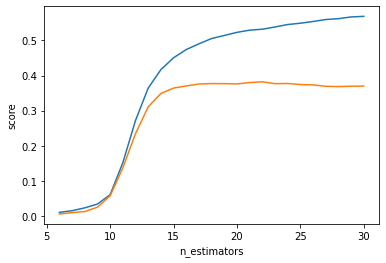

In [55]:
cv_strategy = KFold(n_splits=5)

n_trees, current_score_train, current_score_valid  = [], [], []

for i in tqdm(range(30, 5, -1)):
    estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
    fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
    evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
        target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
        target_train['TST'], 
        target_train['C'],
        test.drop(['DATA_ZAMERA'], axis=1),
        estimator_1=xgb.XGBRegressor(n_estimators=i, random_state=1), 
        estimator_2=xgb.XGBRegressor(n_estimators=i, random_state=1),
        metric=r2_score, 
        cv_strategy=cv_strategy,
        error_to_be_outlier=None,
    )
    
    current_score_train.append(evraz_metric_train_scores_mean)
    current_score_valid.append(evraz_metric_valid_scores_mean)
    n_trees.append(i)

plt.plot(n_trees, current_score_train)
plt.plot(n_trees, current_score_valid)
plt.xlabel('n_estimators')
plt.ylabel('score')
plt.show();

In [56]:
cv_strategy = KFold(n_splits=5)
#cv_strategy = StratifiedKFold(n_splits=5)

n_trees=17

estimators, oof_score_1, oof_score_2, fold_train_scores_1, fold_train_scores_2, fold_valid_scores_1, \
fold_valid_scores_2, oof_predictions_1, oof_predictions_2, test_pred_1, test_pred_2,\
evraz_metric_train_scores_mean, evraz_metric_valid_scores_mean = make_cross_validation(
    target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), 
    target_train['TST'], 
    target_train['C'],
    test.drop(['DATA_ZAMERA'], axis=1),
    estimator_1=xgb.XGBRegressor(n_estimators=n_trees, random_state=1), 
    estimator_2=xgb.XGBRegressor(n_estimators=n_trees, random_state=1),
    metric=r2_score, 
    cv_strategy=cv_strategy,
    error_to_be_outlier=None,
)

Fold: 1, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8084, train-score 2 = 0.9216
valid-score 1 = 0.4167, valid-score 2 = 0.3666
Train metric =  0.4942
Valid metric =  0.339
Fold: 2, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8016, train-score 2 = 0.9138
valid-score 1 = 0.5042, valid-score 2 = 0.5556
Train metric =  0.4888
Valid metric =  0.3959
Fold: 3, train-observations = 1650, valid-observations = 413
train-score 1 = 0.8015, train-score 2 = 0.9247
valid-score 1 = 0.4756, valid-score 2 = 0.5192
Train metric =  0.4882
Valid metric =  0.3814
Fold: 4, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8009, train-score 2 = 0.9212
valid-score 1 = 0.571, valid-score 2 = 0.552
Train metric =  0.49
Valid metric =  0.3835
Fold: 5, train-observations = 1651, valid-observations = 412
train-score 1 = 0.8193, train-score 2 = 0.902
valid-score 1 = 0.4619, valid-score 2 = 0.5088
Train metric =  0.4891
Valid metric =  0.3799
C

In [63]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_pred_1).rename('TST'), 
                    pd.Series(np.exp(test_pred_2)).rename('C')
                   ],
                   axis=1
                  )
print(submit.shape)
submit.head(5)

(780, 3)


,NPLV,TST,C
0,512324,1639.152954,0.044117
1,512327,1668.477661,0.068015
2,512328,1645.428833,0.082462
3,512331,1657.093994,0.089369
4,512333,1664.839233,0.095829


In [64]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'xgb_n-tree-17_all_feats_log10_exp_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  xgb_n-tree-17_all_feats_log10_exp_2021-11-01_20-14-19.csv

 File saved to disk!
